# LAB 2



Подгрузим все либы + датасет

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, classification_report, ConfusionMatrixDisplay, RocCurveDisplay
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

df = pd.read_csv('Titanic-Dataset.csv')
print(f"Размер датасета: {df.shape}")
df.head()

Размер датасета: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Глянем пропуски, видим уже NaN у Cabin


In [25]:
print(df.isnull().sum())
print()
df.info()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Слишком много пропусков в параметре Cabin, можем в целом дропнуть, вряд ли даст какой-то импакт для модели. Посмотрим на количество выживших

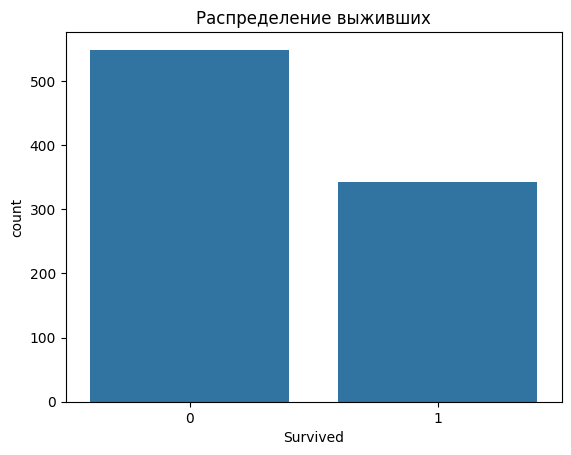

In [26]:
sns.countplot(x="Survived", data=df)
plt.title("Распределение выживших")
plt.show()

Я предлагаю Name и Ticket дропнуть, т.к. это сложные текстовые поля, которое вряд ли каким-то образом влияет. Сам Ticket наверняка имеет корелляцию с классом пассажира, проверим это.

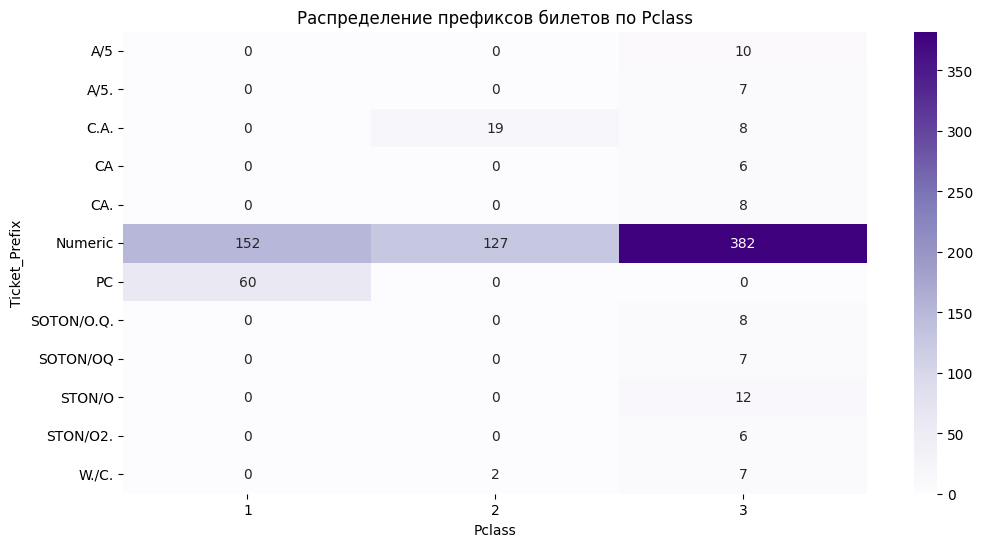

In [27]:
def get_ticket_prefix(ticket):
    parts = ticket.split()
    if not parts[0].isdigit():
        return parts[0]
    return "Numeric"

df_temp = df.copy()
df_temp['Ticket_Prefix'] = df_temp['Ticket'].apply(get_ticket_prefix)

cross_tab = pd.crosstab(df_temp['Ticket_Prefix'], df_temp['Pclass'])


plt.figure(figsize=(12, 6))
sns.heatmap(cross_tab.loc[cross_tab.sum(axis=1) > 5], annot=True, fmt='d', cmap='Purples')
plt.title('Распределение префиксов билетов по Pclass')
plt.show()

И да, это верно. PC - вообще только 1ый класс, видимо премиальные билеты. Но Ticket в датасете будет только мешать, и т.к. Pclass уже содержит информацию о классе (а ещё у нас есть Fare(цена, тариф)), надо действительно избавляться от Ticket.  

In [28]:
num_features = ["Age", "SibSp", "Parch", "Fare"]

cat_features = ["Pclass", "Sex", "Embarked"] 

target = "Survived"

X = df[num_features + cat_features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Для сборки pipeline посмотрим статистику по числовым признакам

In [29]:
stats_df = df[num_features].agg(["min", "mean", "max"]).T

print("Статистика по числовым признакам:")
print(stats_df)

Статистика по числовым признакам:
        min       mean       max
Age    0.42  29.699118   80.0000
SibSp  0.00   0.523008    8.0000
Parch  0.00   0.381594    6.0000
Fare   0.00  32.204208  512.3292


Ну в общем данные ни разу не близки друг к другу, выбросы встречаются.

In [30]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

prepocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

model = Pipeline(steps=[
    ('preprocessor', prepocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

Обучаем модель и смотрим на метрики

Mertics on Test Set:
Accuracy:  0.7989
ROC-AUC:   0.8762
F1 Score:  0.7465
------------------------------
Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.86      0.83       105
           1       0.78      0.72      0.75        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



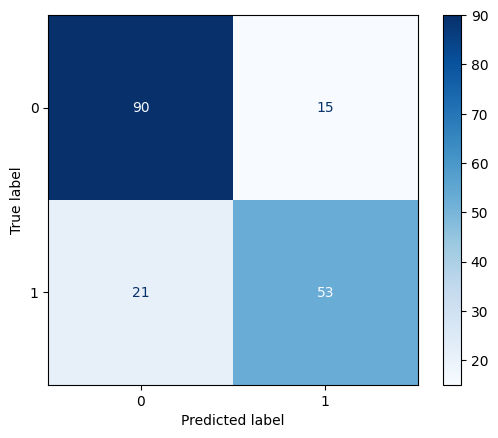

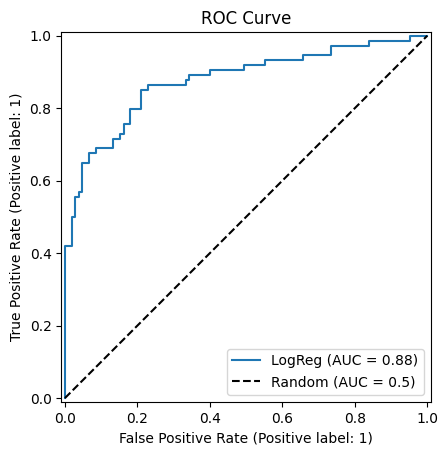

In [31]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Mertics on Test Set:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_proba):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred):.4f}")
print("-" * 30)
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')

RocCurveDisplay.from_estimator(
    model, 
    X_test, 
    y_test, 
    name='LogReg'
)
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')
plt.title('ROC Curve')
plt.legend()
plt.show()

Все метрики посчитаны, осталось проверить влияние threshold. 

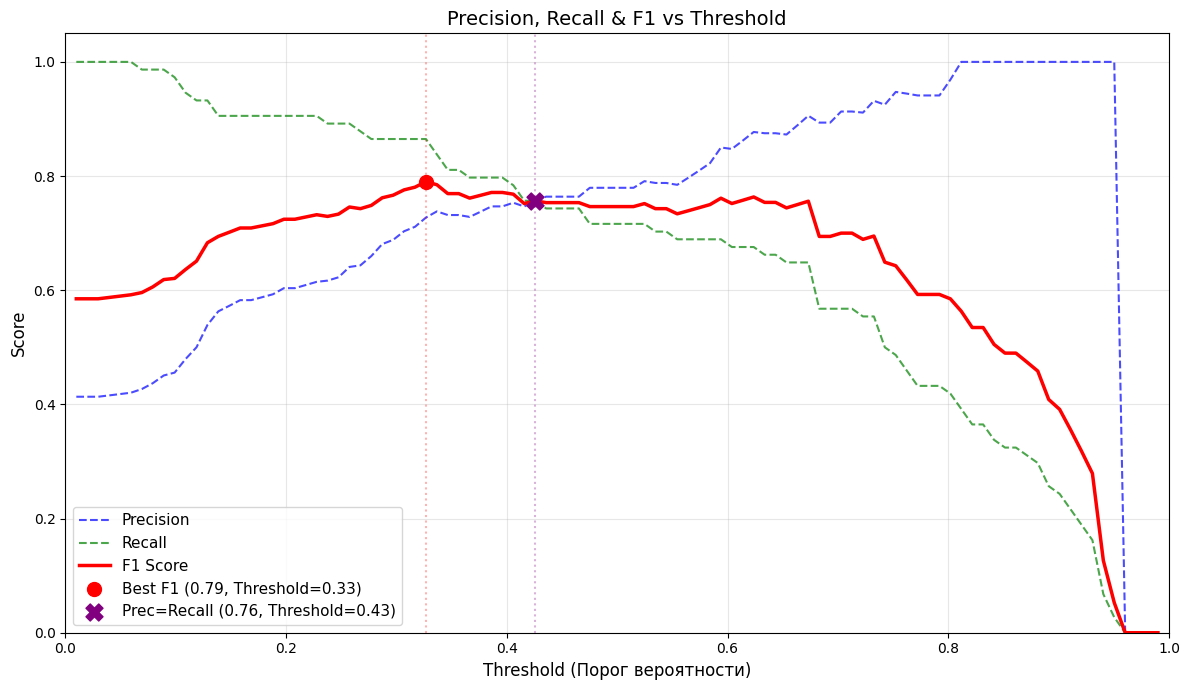

In [ ]:
thresholds_range = np.linspace(0.01, 0.99, 100)

precisions = []
recalls = []
f1_scores = []

for thr in thresholds_range:
    y_pred_thr = (y_proba >= thr).astype(int)
    precisions.append(precision_score(y_test, y_pred_thr, zero_division=0))
    recalls.append(recall_score(y_test, y_pred_thr, zero_division=0))
    f1_scores.append(f1_score(y_test, y_pred_thr, zero_division=0))

precisions = np.array(precisions)
recalls = np.array(recalls)
f1_scores = np.array(f1_scores)

best_f1_idx = np.argmax(f1_scores)
best_f1 = f1_scores[best_f1_idx]
best_thr = thresholds_range[best_f1_idx]

idx_intersect = np.argmin(np.abs(precisions - recalls))
intersect_thr = thresholds_range[idx_intersect]
intersect_val = precisions[idx_intersect]

plt.figure(figsize=(12, 7))

plt.plot(thresholds_range, precisions, label='Precision', color='blue', linestyle='--', alpha=0.7)
plt.plot(thresholds_range, recalls, label='Recall', color='green', linestyle='--', alpha=0.7)
plt.plot(thresholds_range, f1_scores, label='F1 Score', color='red', linewidth=2.5)

plt.scatter(best_thr, best_f1, marker='o', color='red', s=100, zorder=10,
            label=f'Best F1 ({best_f1:.2f}, Threshold={best_thr:.2f})')
plt.axvline(x=best_thr, color='red', linestyle=':', alpha=0.3)

plt.scatter(intersect_thr, intersect_val, marker='X', color='purple', s=150, zorder=10,
            label=f'Prec=Recall ({intersect_val:.2f}, Threshold={intersect_thr:.2f})')
plt.axvline(x=intersect_thr, color='purple', linestyle=':', alpha=0.3)

plt.title('Precision, Recall & F1 vs Threshold', fontsize=14)
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.legend(loc='lower left', fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim(0, 1)
plt.ylim(0, 1.05)

plt.tight_layout()
plt.show()


### Вывод:
#### 1) Модель показала ROC-AUC = 0.87, Accuracy=0.8 (округлённо). Not bad мне кажется :)
#### 2) Модель лучше предсказывает погибших, чем выживших. (90 против 51). Ошибок, когда погибшего посчитали выжившим - 15, и ошибок наоборот - 21.
#### 3) Наиболее оптимальным Threshold с точки зрения лучшего F1 Score является значение 0.33. Precision и Recall равны друг другу при Threshold = 0.43.

#### Для этой задачи наиболее оптимальным является Threshold=0.43, который даёт баланс между Precision и Recall с хорошим F1 Score.


# LAB 3


Переходим к 3ьей лабе. Вспомним базовые показатели

In [33]:
y_pred_base = model.predict(X_test)
y_proba_base = model.predict_proba(X_test)[:, 1]

base_f1 = f1_score(y_test, y_pred_base)
base_acc = accuracy_score(y_test, y_pred_base)
base_auc = roc_auc_score(y_test, y_proba_base)

print(f"Базовый F1 Score: {base_f1:.4f}")
print(f"Базовая Accuracy: {base_acc:.4f}")
print(f"Базовый ROC-AUC: {base_auc:.4f}")

Базовый F1 Score: 0.7465
Базовая Accuracy: 0.7989
Базовый ROC-AUC: 0.8762


Начнём работу с гиперпараметрами

In [34]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    "classifier__C": np.logspace(-3, 2, 30),
    "classifier__penalty": ["l1", "l2"],
    "classifier__solver": ["liblinear", "saga"],
}

search = RandomizedSearchCV(
    model,
    param_distributions=param_distributions,
    n_iter=50,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    random_state=42,
)

search.fit(X_train, y_train)

search.best_params_, search.best_score_

/home/sauron/Projects/Labs/ml_labs/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/sauron/Projects/Labs/ml_labs/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


({'classifier__solver': 'saga',
  'classifier__penalty': 'l2',
  'classifier__C': np.float64(0.1743328822199989)},
 np.float64(0.7142323207245339))

Сравним лучшую найденную модель с нашей

In [35]:
best_model = search.best_estimator_

y_pred_best = best_model.predict(X_test)
y_proba_best = best_model.predict_proba(X_test)[:, 1]

metrics = {
    "Model": ["Baseline", "Tuned"],
    "Accuracy": [base_acc, accuracy_score(y_test, y_pred_best)],
    "F1": [base_f1, f1_score(y_test, y_pred_best)],
    "ROC-AUC": [base_auc, roc_auc_score(y_test, y_proba_best)],
}

pd.DataFrame(metrics)

,Model,Accuracy,F1,ROC-AUC
0,Baseline,0.798883,0.746479,0.876190
1,Tuned,0.798883,0.742857,0.875418


### Вывод:
#### RandomizedSearchCV оптимизировал гиперпараметры, но метрики изменились незначительно (F1 упал на ~0.004, ROC-AUC - на ~0.01). Почему так произошло:
#### 1) Стандартный C = 1 у LogisticRegression оказался подходящим для данного датасета, и уже с этим параметром были получены наилучшие результаты
#### 2) Сам датасет маленький, и такие различия можно посчитать результатом шума при разбиении данных

#### Формально, Baseline оказался лучше, но Tuned модель более строгая и на большем датасете выдаст результаты наверняка лучше, чем Baseline, поэтому Tuned модель будет лучше для полноценного использования. Такие дела.